### **Gender Distribution**

Churn,0.000000,1.000000
Gender,,
Female,33.33%,66.67%
Male,50.87%,49.13%


### **Subscription Type Distribution**

Churn,0.000000,1.000000
Subscription Type,,
Basic,41.82%,58.18%
Premium,44.06%,55.94%
Standard,43.93%,56.07%


### **Contract Length Distribution**

Churn,0.000000,1.000000
Contract Length,,
Annual,53.92%,46.08%
Monthly,nan%,100.00%
Quarterly,53.97%,46.03%


### **Age Distribution (Binned)**

Churn,0.000000,1.000000
Age,,
"(17.953, 27.4]",44.15%,55.85%
"(27.4, 36.8]",52.08%,47.92%
"(36.8, 46.2]",57.74%,42.26%
"(46.2, 55.6]",39.45%,60.55%
"(55.6, 65.0]",0.00%,100.00%


### **Tenure Distribution (Binned)**

Churn,0.000000,1.000000
Tenure,,
"(0.941, 12.8]",41.27%,58.73%
"(12.8, 24.6]",36.73%,63.27%
"(24.6, 36.4]",45.88%,54.12%
"(36.4, 48.2]",45.87%,54.13%
"(48.2, 60.0]",45.70%,54.30%


### **Usage Frequency Distribution (Binned)**

Churn,0.000000,1.000000
Usage Frequency,,
"(0.971, 6.8]",38.42%,61.58%
"(6.8, 12.6]",42.21%,57.79%
"(12.6, 18.4]",45.20%,54.80%
"(18.4, 24.2]",44.98%,55.02%
"(24.2, 30.0]",45.13%,54.87%


### **Support Calls Distribution (Binned)**

Churn,0.000000,1.000000
Support Calls,,
"(-0.01, 2.0]",69.28%,30.72%
"(2.0, 4.0]",51.22%,48.78%
"(4.0, 6.0]",2.72%,97.28%
"(6.0, 8.0]",0.00%,100.00%
"(8.0, 10.0]",0.00%,100.00%


### **Payment Delay Distribution (Binned)**

Churn,0.000000,1.000000
Payment Delay,,
"(-0.03, 6.0]",53.52%,46.48%
"(6.0, 12.0]",53.44%,46.56%
"(12.0, 18.0]",53.42%,46.58%
"(18.0, 24.0]",26.95%,73.05%
"(24.0, 30.0]",0.00%,100.00%


### **Total Spend Distribution (Binned)**

Churn,0.000000,1.000000
Total Spend,,
"(99.1, 280.0]",0.00%,100.00%
"(280.0, 460.0]",0.00%,100.00%
"(460.0, 640.0]",52.08%,47.92%
"(640.0, 820.0]",58.62%,41.38%
"(820.0, 1000.0]",58.96%,41.04%


### **Last Interaction Distribution (Binned)**

Churn,0.000000,1.000000
Last Interaction,,
"(0.971, 6.8]",50.80%,49.20%
"(6.8, 12.6]",50.72%,49.28%
"(12.6, 18.4]",43.34%,56.66%
"(18.4, 24.2]",33.46%,66.54%
"(24.2, 30.0]",33.45%,66.55%


Size of the dataset:
(440833, 12)
First 5 Rows of the Dataset:
   CustomerID   Age  Gender  Tenure  Usage Frequency  Support Calls  \
0         2.0  30.0  Female    39.0             14.0            5.0   
1         3.0  65.0  Female    49.0              1.0           10.0   
2         4.0  55.0  Female    14.0              4.0            6.0   
3         5.0  58.0    Male    38.0             21.0            7.0   
4         6.0  23.0    Male    32.0             20.0            5.0   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0           18.0          Standard          Annual        932.0   
1            8.0             Basic         Monthly        557.0   
2           18.0             Basic       Quarterly        185.0   
3            7.0          Standard         Monthly        396.0   
4            8.0             Basic         Monthly        617.0   

   Last Interaction  Churn  
0              17.0    1.0  
1               6.0    1.0  
2               3.0 

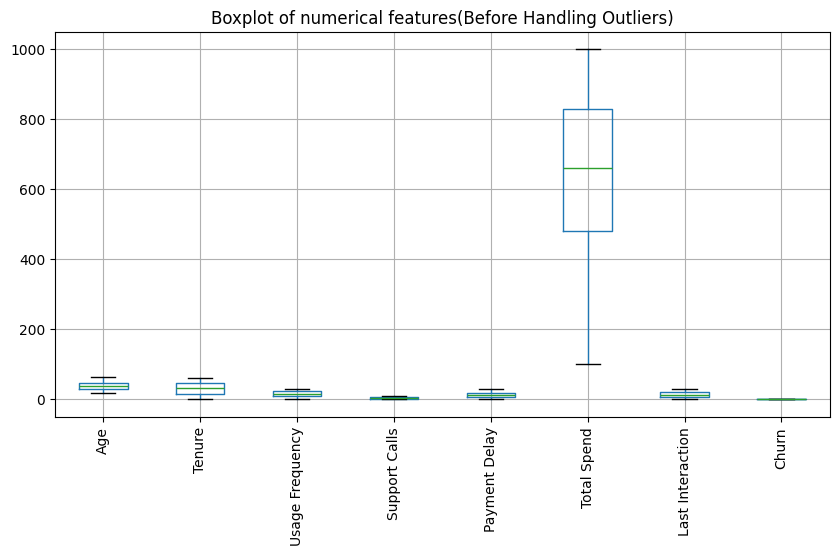

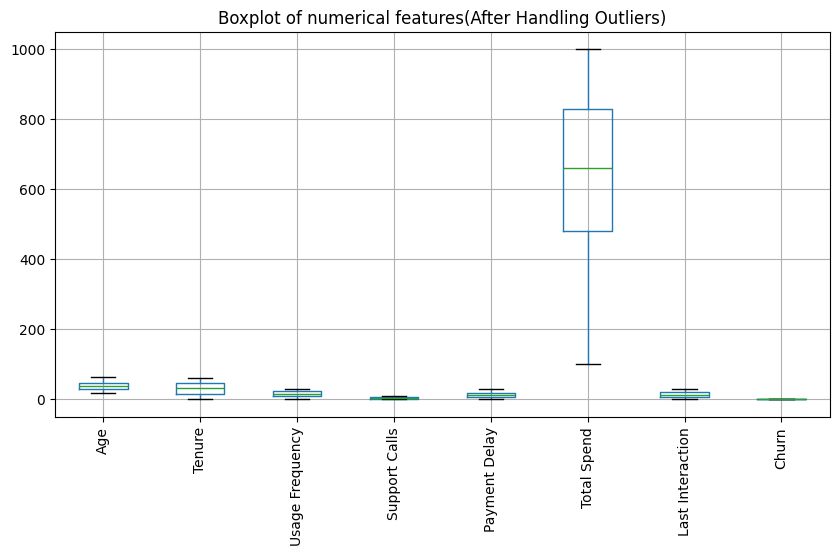

<Figure size 1200x800 with 0 Axes>

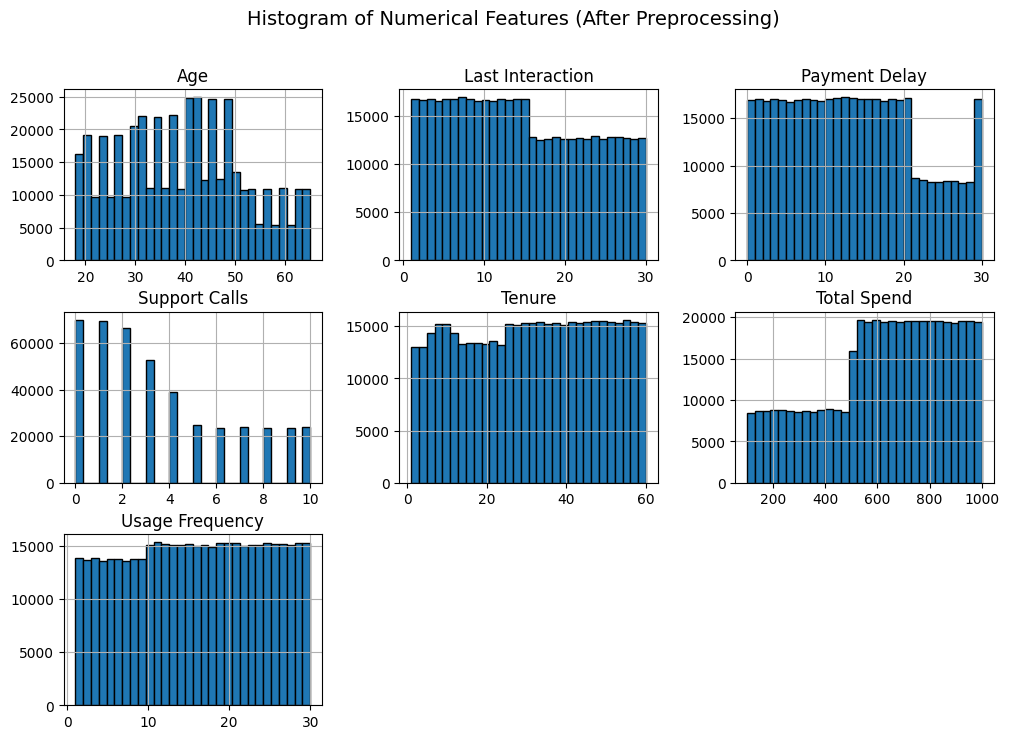

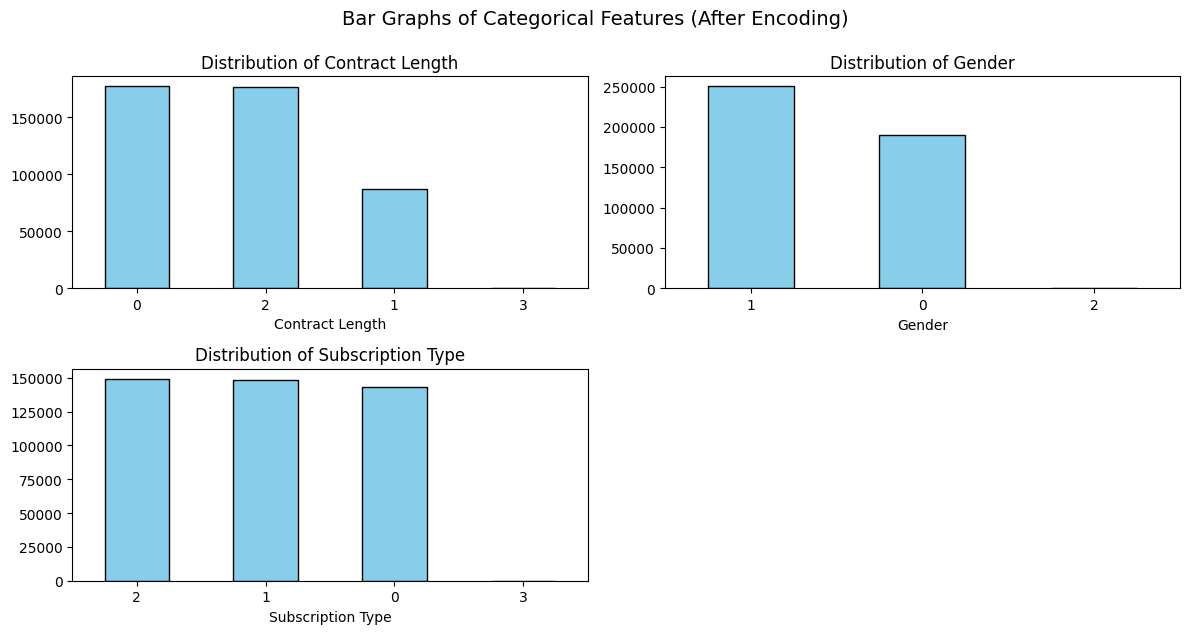

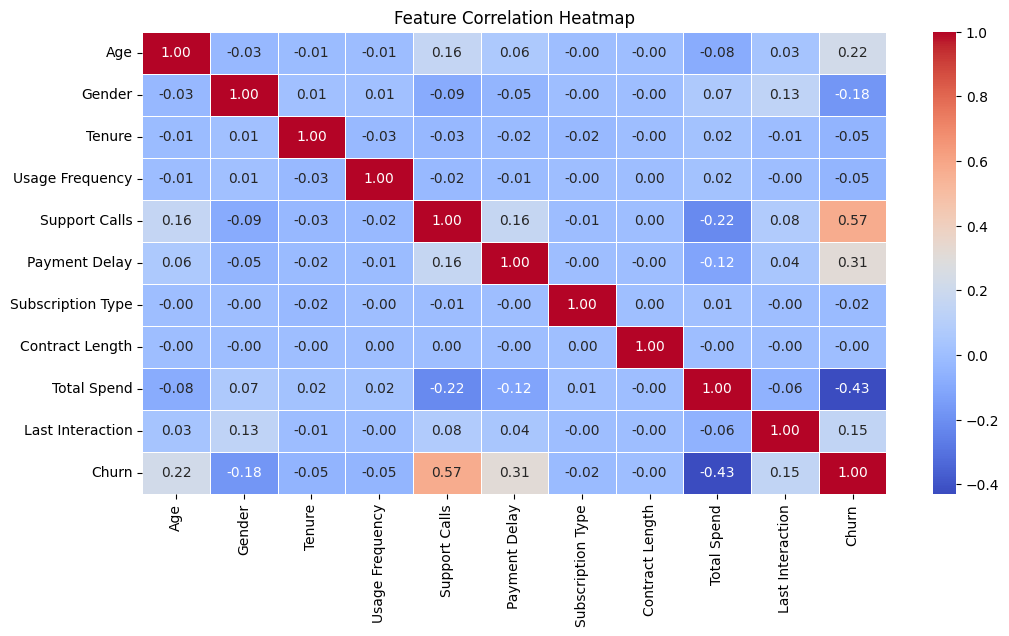


Logistic Regression Performance:
Train Accuracy: 0.8512983956491411
Test Accuracy: 0.8510213571971372
Area Under the Curve (AUC-ROC): 0.9282294002672467


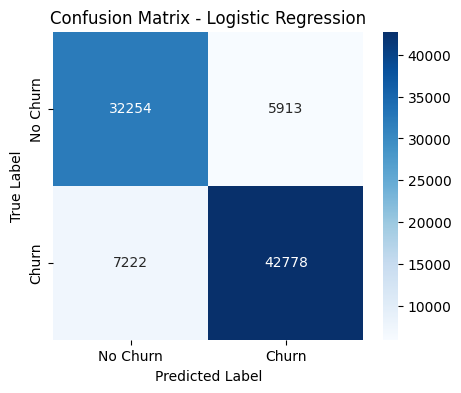

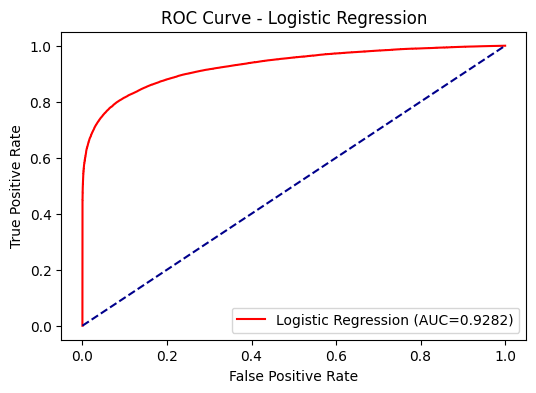


Decision Tree Performance:
Train Accuracy: 1.0
Test Accuracy: 0.9998412104302064
Area Under the Curve (AUC-ROC): 0.9998413980663923


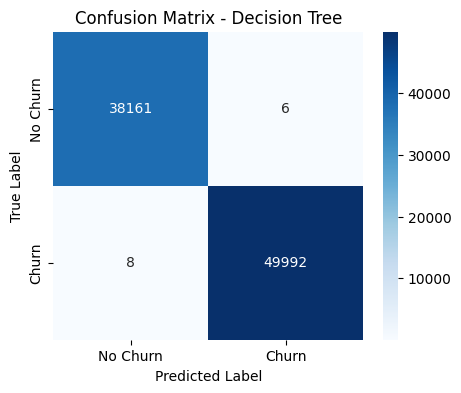

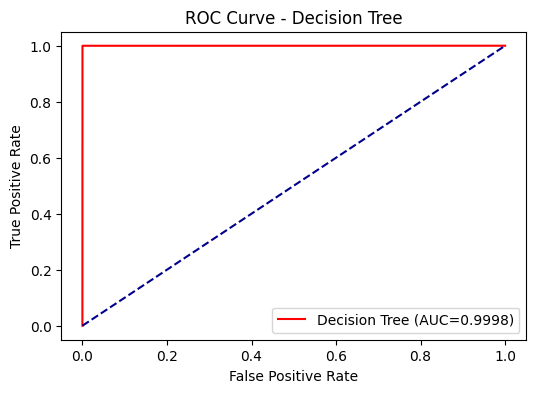


Random Forest Performance:
Train Accuracy: 1.0
Test Accuracy: 0.9997958419816938
Area Under the Curve (AUC-ROC): 0.9999990295281265


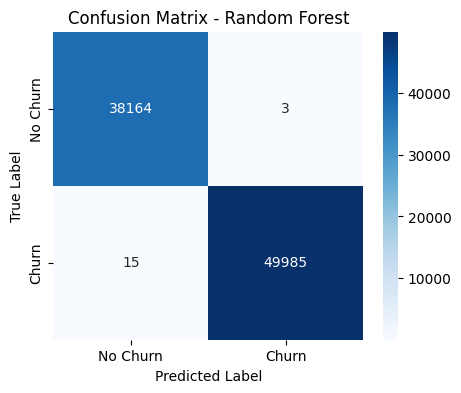

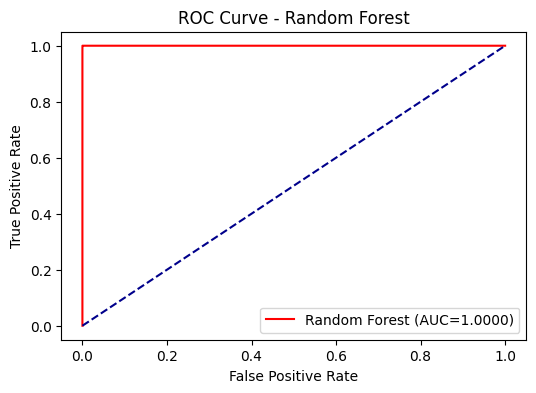


XGBoost Performance:
Train Accuracy: 0.9999801511912121
Test Accuracy: 0.9998412104302064
Area Under the Curve (AUC-ROC): 0.9999994550265936


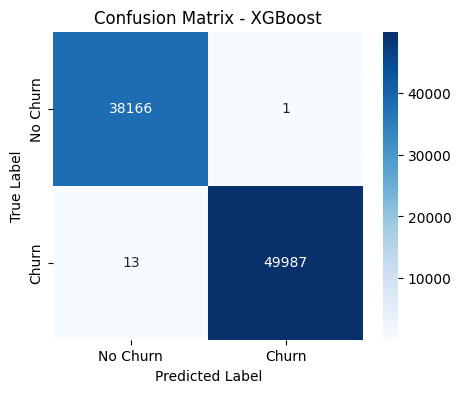

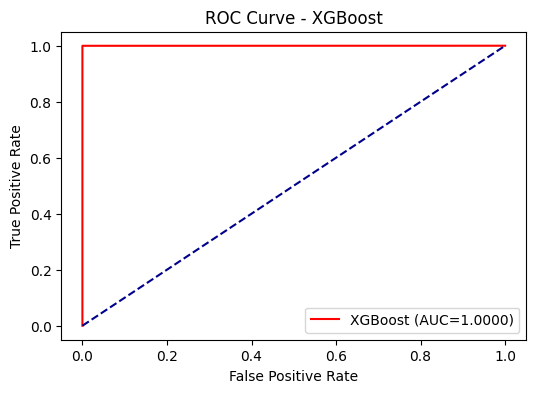

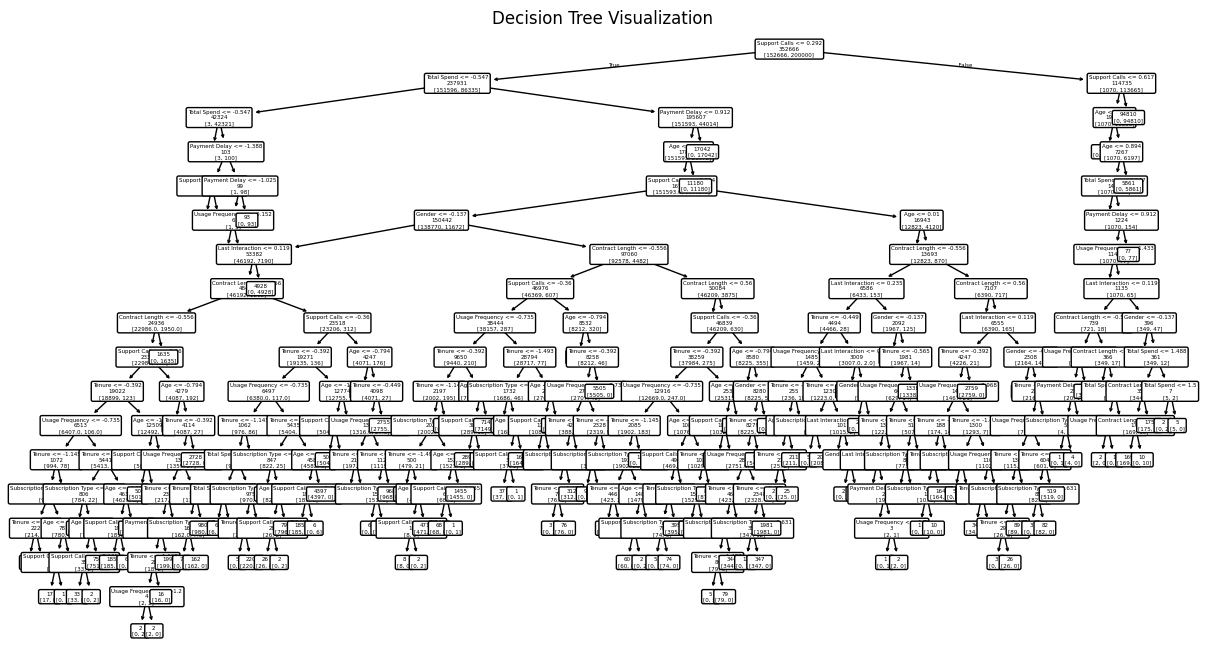


Model Performance Summary:
                 Model  Train Accuracy  Test Accuracy   AUC-ROC
0  Logistic Regression        0.851298       0.851021  0.928229
1        Decision Tree        1.000000       0.999841  0.999841
2        Random Forest        1.000000       0.999796  0.999999
3              XGBoost        0.999980       0.999841  0.999999
╒════╤═════════════════════╤══════════════════╤═════════════════╤═══════════╕
│    │ Model               │   Train Accuracy │   Test Accuracy │   AUC-ROC │
╞════╪═════════════════════╪══════════════════╪═════════════════╪═══════════╡
│  0 │ Logistic Regression │         0.851298 │        0.851021 │  0.928229 │
├────┼─────────────────────┼──────────────────┼─────────────────┼───────────┤
│  1 │ Decision Tree       │         1        │        0.999841 │  0.999841 │
├────┼─────────────────────┼──────────────────┼─────────────────┼───────────┤
│  2 │ Random Forest       │         1        │        0.999796 │  0.999999 │
├────┼─────────────────────┼

In [ ]:
#Reqiured libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score,roc_curve
import warnings
warnings.filterwarnings('ignore')


# Load dataset
file_path = "/content/customer_churn_dataset-training-master.csv"  # Update path in Colab
df = pd.read_csv(file_path)

# Function to compute percentage distribution for categorical features
def categorical_distribution(feature):
    table = df.groupby([feature, 'Churn']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1)
    return table.style.format("{:.2f}%").applymap(color_cells)

# Function to compute percentage distribution for numerical features
def numerical_distribution(feature, bins=5):
    df_binned = pd.cut(df[feature], bins=bins)
    table = df.groupby([df_binned, 'Churn']).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1)
    return table.style.format("{:.2f}%").applymap(color_cells)

# Function to add colors to cells
def color_cells(value):
    if value > 70:
        color = 'red'  # High churn risk
    elif value > 50:
        color = 'orange'
    elif value > 30:
        color = 'yellow'
    else:
        color = 'green'  # Low churn risk
    return f"background-color: {color}; color: black;"

# Categorical features
categorical_features = ['Gender', 'Subscription Type', 'Contract Length']
for feature in categorical_features:
    display(Markdown(f"### **{feature} Distribution**"))
    display(categorical_distribution(feature))

# Numerical features
numerical_features = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']
for feature in numerical_features:
    display(Markdown(f"### **{feature} Distribution (Binned)**"))
    display(numerical_distribution(feature))

#Basic info
print("Size of the dataset:")
print(df.shape)
print("First 5 Rows of the Dataset:")
print(df.head())

#Summary statistics
print("\nSummary Statistics:")
print(df.describe())

#Drop "CustomerID" as it is a unique identifier
if "CustomerID" in df.columns or "customer_id" in df.columns:
  df.drop(columns=["CustomerID","customer_id"],errors='ignore',inplace=True)

#Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

#Boxplot for outliers before handling
plt.figure(figsize=(10,5))
df.select_dtypes(include=['number']).boxplot()
plt.title('Boxplot of numerical features(Before Handling Outliers)')
plt.xticks(rotation=90)
plt.show()

#Function to handle outliers using IQR and replace with mean
def handle_outliers_with_mean(df):
    numerical_cols = df.select_dtypes(include=['number']).columns
    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_index = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index  # Get the index of outliers
        if len(outliers_index) > 0:  # Check if there are any outliers
            mean_value = df[col].mean()
            df.loc[outliers_index, col] = mean_value  # Use the index to update the values
    return df

#Applying outlier handling function
df=handle_outliers_with_mean(df)

#Boxplot after handling outliers
plt.figure(figsize=(10,5))
df.select_dtypes(include=['number']).boxplot()
plt.title('Boxplot of numerical features(After Handling Outliers)')
plt.xticks(rotation=90)
plt.show()

#Handling missing values
imputer = SimpleImputer(strategy='median')
df[df.select_dtypes(include=['number']).columns]=imputer.fit_transform(df.select_dtypes(include=['number']))

# Histogram for numerical values
numerical_cols = df.select_dtypes(include=['number']).columns.difference(['Churn'])
plt.figure(figsize=(12, 8))
df[numerical_cols].hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle("Histogram of Numerical Features (After Preprocessing)", fontsize=14)
plt.show()

#Encoding categorical variables
label_encoders={}
for col in df.select_dtypes(include=['object']).columns:
  le=LabelEncoder()
  df[col]=le.fit_transform(df[col])
  label_encoders[col]=le

# Bar graphs for categorical features after encoding
categorical_cols = df.select_dtypes(include=['int', 'category']).columns.difference(['Churn'])

plt.figure(figsize=(12, 6))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, (len(categorical_cols) + 1) // 2, i)
    df[col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=0)
plt.tight_layout()
plt.suptitle("Bar Graphs of Categorical Features (After Encoding)", fontsize=14, y=1.05)
plt.show()

# Scaling only numerical features
numerical_cols = df.select_dtypes(include=['number']).columns.difference(['Churn'])
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Defining features and target
X = df.drop(columns=['Churn'])
y = df['Churn']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Dictionary to store model performance
model_performance = {
    "Model": [],
    "Train Accuracy": [],
    "Test Accuracy": [],
    "AUC-ROC": []
}

# Function to train and evaluate model
def train_and_evaluate(model, model_name):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Metrics Calculation
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    auc = roc_auc_score(y_test, y_pred_prob) if y_pred_prob is not None else "N/A"

    # Store results in the dictionary
    model_performance["Model"].append(model_name)
    model_performance["Train Accuracy"].append(train_acc)
    model_performance["Test Accuracy"].append(test_acc)
    model_performance["AUC-ROC"].append(auc if auc != "N/A" else "Not Available")

    # Print metrics for each model
    print(f"\n{model_name} Performance:")
    print(f"Train Accuracy: {train_acc}")
    print(f"Test Accuracy: {test_acc}")
    print(f"Area Under the Curve (AUC-ROC): {auc if auc != 'N/A' else 'Not Available'}")
    cm=confusion_matrix(y_test,y_test_pred)

    #Plot Confusion Matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(cm,annot=True,fmt='d',cmap='Blues', xticklabels=["No Churn","Churn"], yticklabels=["No Churn","Churn"])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

    #Plot ROC Curve
    fpr,tpr,_=roc_curve(y_test,y_pred_prob)
    plt.figure(figsize=(6,4))
    plt.plot(fpr,tpr,color='red',label=f"{model_name} (AUC={auc:.4f})")
    plt.plot([0,1],[0,1],color='darkblue',linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

# Defining models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Train and evaluate all models
for name, model in models.items():
    train_and_evaluate(model, name)

decision_tree_model=DecisionTreeClassifier()
decision_tree_model.fit(X_train,y_train)

plt.figure(figsize=(15,8))
plot_tree(decision_tree_model,filled=False,feature_names=X.columns,class_names=None, impurity=False, proportion=False, rounded=True,label='none',fontsize=4)
plt.title("Decision Tree Visualization")
plt.show()

# Display results in tabular format
df_results = pd.DataFrame(model_performance)
print("\nModel Performance Summary:")
print(df_results)

# Optional: Pretty print using tabulate (if installed)
try:
    from tabulate import tabulate
    print(tabulate(df_results, headers='keys', tablefmt='fancy_grid'))
except ImportError:
    print(df_results)


Feature: Contract Length
Value: Annual
  Logistic Regression Accuracy: 0.8683
  Decision Tree Accuracy: 0.9997
  Random Forest Accuracy: 0.9996
  XGBoost Accuracy: 0.9999


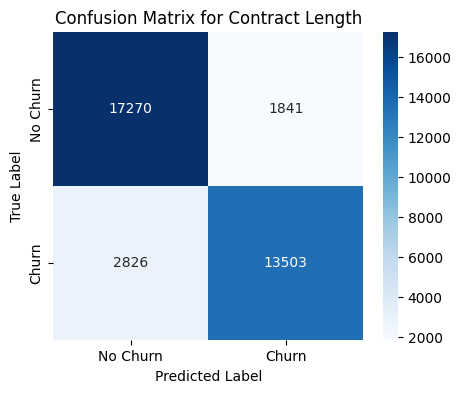

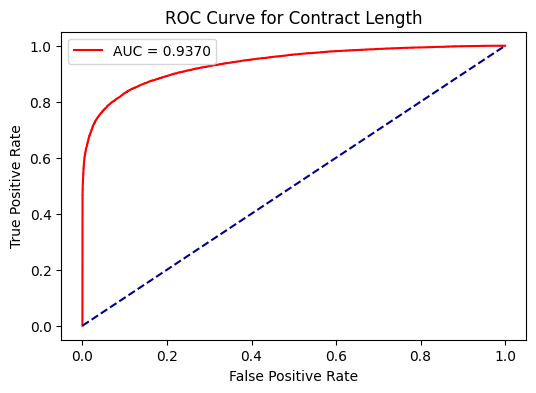

Value: Quarterly
  Logistic Regression Accuracy: 0.8693
  Decision Tree Accuracy: 0.9999
  Random Forest Accuracy: 0.9996
  XGBoost Accuracy: 1.0000

Feature: Gender
Value: Female
  Logistic Regression Accuracy: 0.8754
  Decision Tree Accuracy: 0.9998
  Random Forest Accuracy: 0.9997
  XGBoost Accuracy: 1.0000


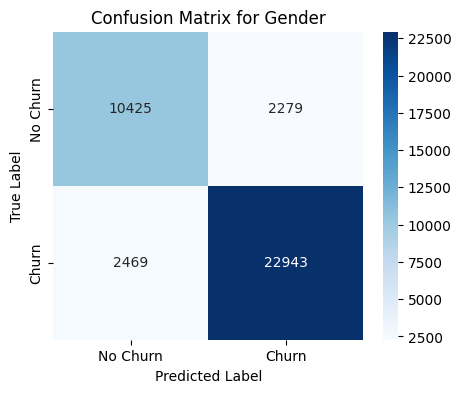

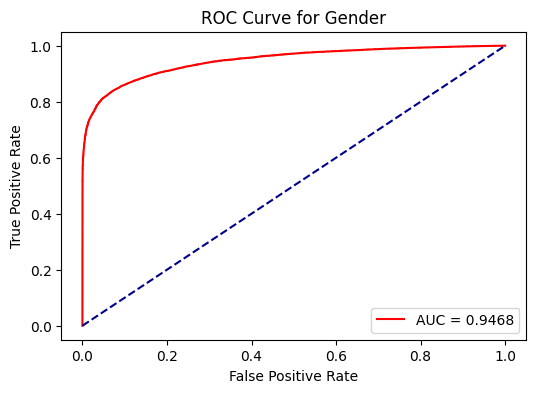

Value: Male
  Logistic Regression Accuracy: 0.8513
  Decision Tree Accuracy: 0.9999
  Random Forest Accuracy: 0.9998
  XGBoost Accuracy: 0.9998

Feature: Subscription Type
Value: Standard
  Logistic Regression Accuracy: 0.8506
  Decision Tree Accuracy: 0.9998
  Random Forest Accuracy: 0.9992
  XGBoost Accuracy: 0.9996


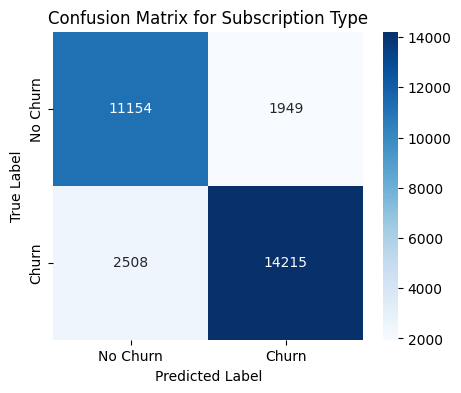

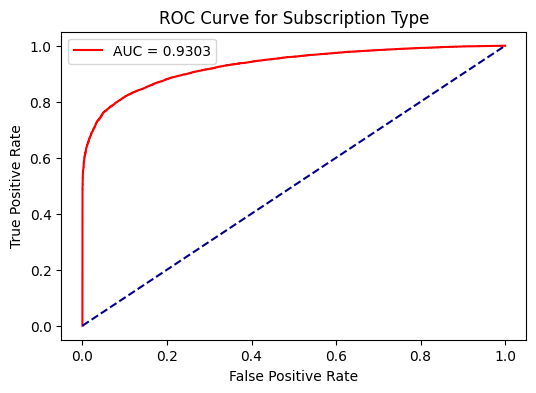

Value: Basic
  Logistic Regression Accuracy: 0.8549
  Decision Tree Accuracy: 0.9995
  Random Forest Accuracy: 0.9991
  XGBoost Accuracy: 0.9999
Value: Premium
  Logistic Regression Accuracy: 0.8488
  Decision Tree Accuracy: 0.9999
  Random Forest Accuracy: 0.9994
  XGBoost Accuracy: 0.9997

Feature: Age
Value: (27.0, 35.0]
  Logistic Regression Accuracy: 0.8807
  Decision Tree Accuracy: 0.9995
  Random Forest Accuracy: 0.9985
  XGBoost Accuracy: 0.9997


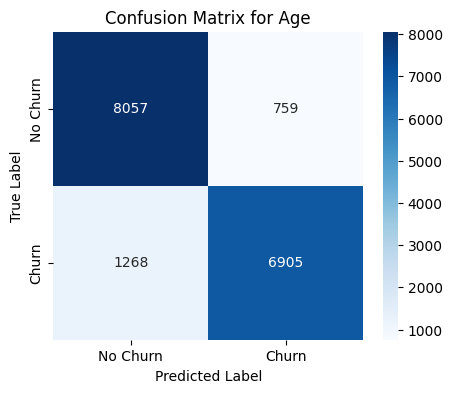

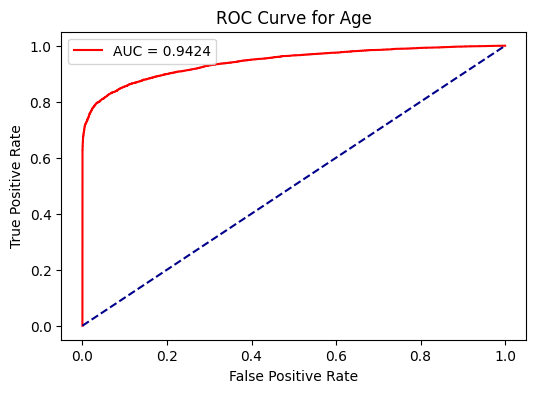

Value: (17.999, 27.0]
  Logistic Regression Accuracy: 0.8995
  Decision Tree Accuracy: 0.9996
  Random Forest Accuracy: 0.9988
  XGBoost Accuracy: 0.9997
Value: (35.0, 43.0]
  Logistic Regression Accuracy: 0.8691
  Decision Tree Accuracy: 0.9994
  Random Forest Accuracy: 0.9983
  XGBoost Accuracy: 1.0000
Value: (43.0, 50.0]
  Logistic Regression Accuracy: 0.8596
  Decision Tree Accuracy: 0.9999
  Random Forest Accuracy: 0.9997
  XGBoost Accuracy: 0.9994

Feature: Last Interaction
Value: (11.0, 17.0]
  Logistic Regression Accuracy: 0.8493
  Decision Tree Accuracy: 0.9985
  Random Forest Accuracy: 0.9980
  XGBoost Accuracy: 0.9998


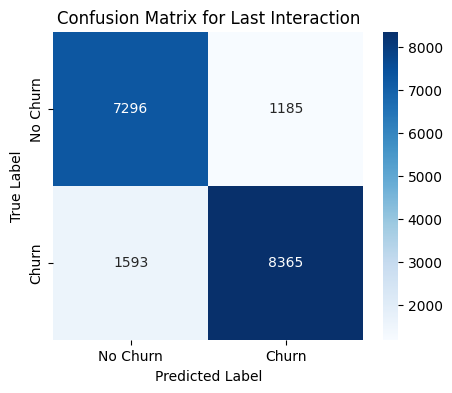

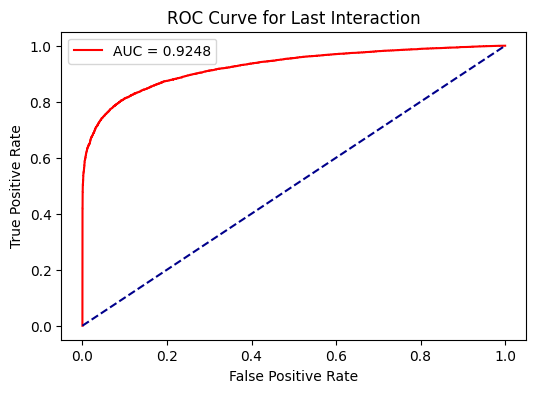

Value: (0.999, 6.0]
  Logistic Regression Accuracy: 0.8540
  Decision Tree Accuracy: 0.9995
  Random Forest Accuracy: 0.9993
  XGBoost Accuracy: 0.9997
Value: (24.0, 30.0]
  Logistic Regression Accuracy: 0.9038
  Decision Tree Accuracy: 0.9997
  Random Forest Accuracy: 0.9991
  XGBoost Accuracy: 1.0000
Value: (17.0, 24.0]
  Logistic Regression Accuracy: 0.9097
  Decision Tree Accuracy: 0.9996
  Random Forest Accuracy: 0.9990
  XGBoost Accuracy: 0.9999
Value: (6.0, 11.0]
  Logistic Regression Accuracy: 0.8492
  Decision Tree Accuracy: 0.9989
  Random Forest Accuracy: 0.9990
  XGBoost Accuracy: 0.9996

Feature: Payment Delay
Value: (15.0, 20.0]
  Logistic Regression Accuracy: 0.8562
  Decision Tree Accuracy: 0.9986
  Random Forest Accuracy: 0.9975
  XGBoost Accuracy: 1.0000


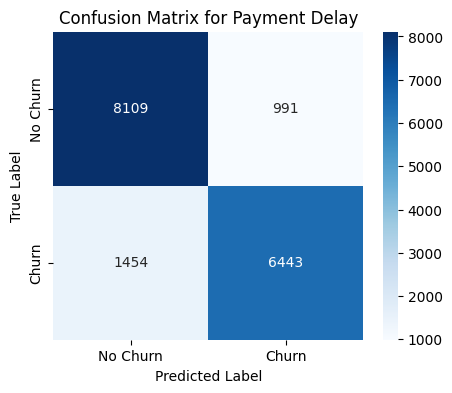

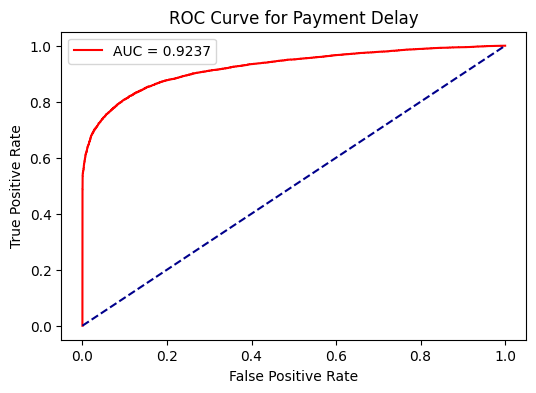

Value: (5.0, 10.0]
  Logistic Regression Accuracy: 0.8595
  Decision Tree Accuracy: 0.9988
  Random Forest Accuracy: 0.9982
  XGBoost Accuracy: 0.9996
Value: (10.0, 15.0]
  Logistic Regression Accuracy: 0.8533
  Decision Tree Accuracy: 0.9988
  Random Forest Accuracy: 0.9981
  XGBoost Accuracy: 0.9994
Value: (-0.001, 5.0]
  Logistic Regression Accuracy: 0.8505
  Decision Tree Accuracy: 0.9996
  Random Forest Accuracy: 0.9981
  XGBoost Accuracy: 0.9999

Feature: Support Calls
Value: (4.0, 7.0]
  Logistic Regression Accuracy: 0.9810
  Decision Tree Accuracy: 0.9997
  Random Forest Accuracy: 0.9999
  XGBoost Accuracy: 0.9999


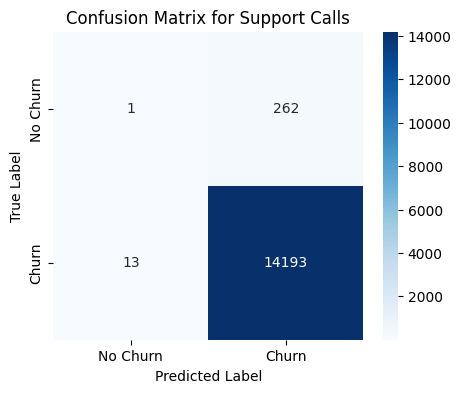

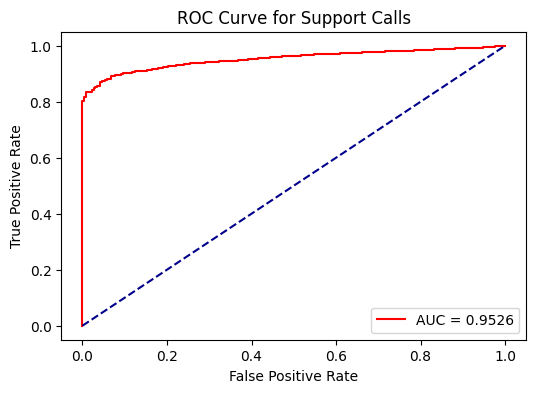

Value: (2.0, 4.0]
  Logistic Regression Accuracy: 0.7597
  Decision Tree Accuracy: 0.9997
  Random Forest Accuracy: 0.9986
  XGBoost Accuracy: 0.9999
Value: (1.0, 2.0]
  Logistic Regression Accuracy: 0.8396
  Decision Tree Accuracy: 0.9996
  Random Forest Accuracy: 0.9987
  XGBoost Accuracy: 0.9995
Value: (-0.001, 1.0]
  Logistic Regression Accuracy: 0.8516
  Decision Tree Accuracy: 1.0000
  Random Forest Accuracy: 0.9999
  XGBoost Accuracy: 1.0000

Feature: Tenure
Value: (38.0, 49.0]
  Logistic Regression Accuracy: 0.8555
  Decision Tree Accuracy: 0.9997
  Random Forest Accuracy: 0.9993
  XGBoost Accuracy: 1.0000


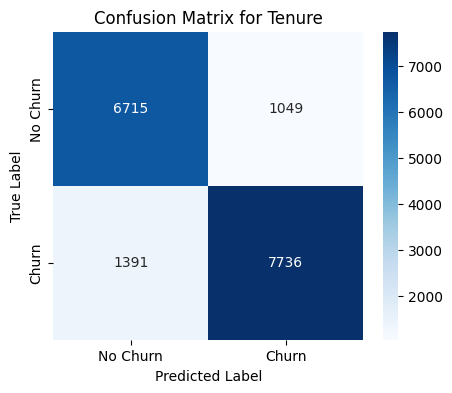

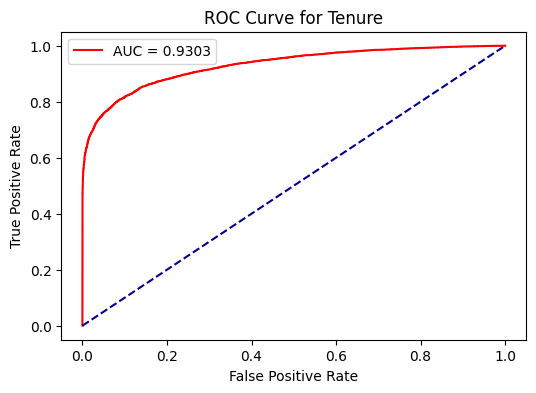

Value: (13.0, 26.0]
  Logistic Regression Accuracy: 0.8557
  Decision Tree Accuracy: 0.9993
  Random Forest Accuracy: 0.9995
  XGBoost Accuracy: 0.9999
Value: (26.0, 38.0]
  Logistic Regression Accuracy: 0.8531
  Decision Tree Accuracy: 0.9999
  Random Forest Accuracy: 0.9995
  XGBoost Accuracy: 0.9999
Value: (0.999, 13.0]
  Logistic Regression Accuracy: 0.8463
  Decision Tree Accuracy: 0.9989
  Random Forest Accuracy: 0.9990
  XGBoost Accuracy: 1.0000
Value: (49.0, 60.0]
  Logistic Regression Accuracy: 0.8556
  Decision Tree Accuracy: 0.9998
  Random Forest Accuracy: 0.9995
  XGBoost Accuracy: 0.9997

Feature: Total Spend
Value: (863.64, 1000.0]
  Logistic Regression Accuracy: 0.8389
  Decision Tree Accuracy: 0.9987
  Random Forest Accuracy: 0.9977
  XGBoost Accuracy: 0.9999


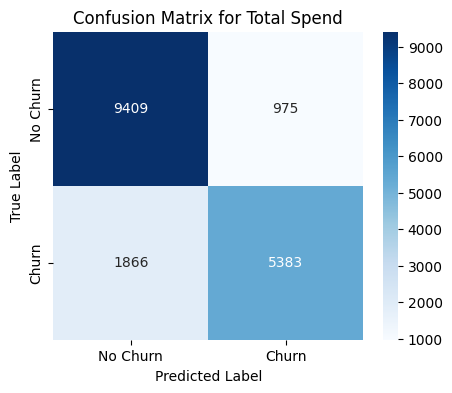

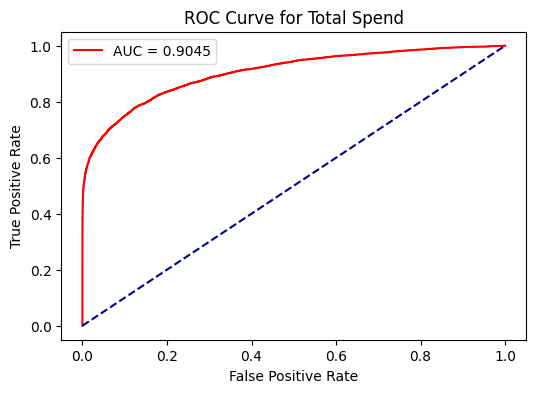

Value: (405.0, 592.778]
  Logistic Regression Accuracy: 0.8634
  Decision Tree Accuracy: 0.9994
  Random Forest Accuracy: 0.9984
  XGBoost Accuracy: 0.9999
Value: (592.778, 728.72]
  Logistic Regression Accuracy: 0.8413
  Decision Tree Accuracy: 0.9989
  Random Forest Accuracy: 0.9977
  XGBoost Accuracy: 1.0000
Value: (728.72, 863.64]
  Logistic Regression Accuracy: 0.8445
  Decision Tree Accuracy: 0.9994
  Random Forest Accuracy: 0.9980
  XGBoost Accuracy: 0.9999

Feature: Usage Frequency
Value: (13.0, 19.0]
  Logistic Regression Accuracy: 0.8569
  Decision Tree Accuracy: 0.9995
  Random Forest Accuracy: 0.9989
  XGBoost Accuracy: 0.9998


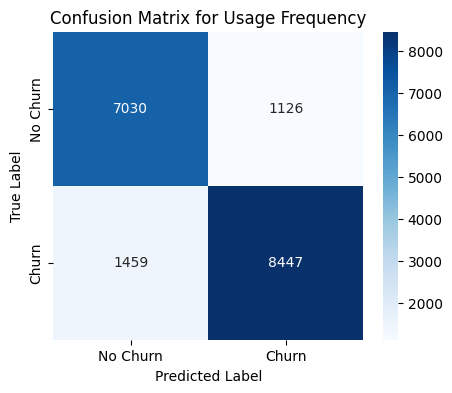

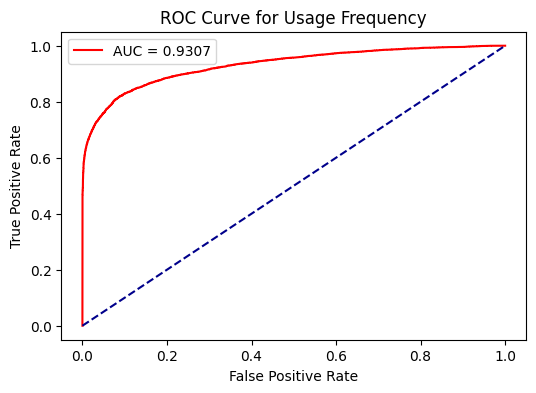

Value: (0.999, 7.0]
  Logistic Regression Accuracy: 0.8487
  Decision Tree Accuracy: 0.9993
  Random Forest Accuracy: 0.9991
  XGBoost Accuracy: 0.9997
Value: (19.0, 25.0]
  Logistic Regression Accuracy: 0.8513
  Decision Tree Accuracy: 0.9998
  Random Forest Accuracy: 0.9997
  XGBoost Accuracy: 0.9999
Value: (7.0, 13.0]
  Logistic Regression Accuracy: 0.8502
  Decision Tree Accuracy: 0.9990
  Random Forest Accuracy: 0.9986
  XGBoost Accuracy: 0.9998
Value: (25.0, 30.0]
  Logistic Regression Accuracy: 0.8500
  Decision Tree Accuracy: 0.9997
  Random Forest Accuracy: 0.9994
  XGBoost Accuracy: 1.0000

Final Results Table:
╒════╤═══════════════════╤═══════════════════╤═══════════════════════╤═════════════════╤═════════════════╤═══════════╕
│    │ Feature           │ Value             │   Logistic Regression │   Decision Tree │   Random Forest │   XGBoost │
╞════╪═══════════════════╪═══════════════════╪═══════════════════════╪═════════════════╪═════════════════╪═══════════╡
│ 20 │ Support

In [5]:
# Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings("ignore")

# Load dataset
file_path = "/content/customer_churn_dataset-training-master.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Drop "CustomerID" if present
df.drop(columns=["CustomerID", "customer_id"], errors="ignore", inplace=True)

# Handle missing values
imputer = SimpleImputer(strategy="median")
df[df.select_dtypes(include=["number"]).columns] = imputer.fit_transform(df.select_dtypes(include=["number"]))

# Encode categorical features but store mappings
label_encoders = {}
categorical_mappings = {}
for col in df.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    categorical_mappings[col] = dict(zip(le.transform(le.classes_), le.classes_))  # Store original labels

# Define categorical and numerical features
categorical_features = df.select_dtypes(include=["int", "category"]).columns.difference(["Churn"]).tolist()
numerical_features = df.select_dtypes(include=["float", "int"]).columns.difference(["Churn"] + categorical_features).tolist()

# Function to evaluate a feature
def evaluate_feature(feature, subsets):
    print(f"\nFeature: {feature}")

    # Store feature-level results, ensuring unique entries
    feature_results = []
    seen_values = set()  # Track encountered values to avoid duplicates

    for value, subset in subsets.items():
        if len(subset) < 50 or subset["Churn"].nunique() == 1:
            continue  # Skip small or single-class subsets

        X = subset.drop(columns=["Churn"])
        y = subset["Churn"]

        # Split into train-test sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

        # Scale numerical features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Define models
        models = {
            "Logistic Regression": LogisticRegression(),
            "Decision Tree": DecisionTreeClassifier(),
            "Random Forest": RandomForestClassifier(),
            "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
        }

        model_accuracies = {}

        for model_name, model in models.items():
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            model_accuracies[model_name] = accuracy

        # Convert feature value back to original category name if categorical
        if feature in categorical_mappings:
            original_value = categorical_mappings[feature].get(value, value)
        else:
            original_value = str(value)  # Keep numerical values as is but ensure consistent string representation

        # Skip duplicates
        if original_value in seen_values:
            continue
        seen_values.add(original_value)

        # Print accuracy for all models
        print(f"Value: {original_value}")
        for model_name, acc in model_accuracies.items():
            print(f"  {model_name} Accuracy: {acc:.4f}")

        # Store results
        feature_results.append({
            "Feature": feature,
            "Value": original_value,
            "Logistic Regression": model_accuracies["Logistic Regression"],
            "Decision Tree": model_accuracies["Decision Tree"],
            "Random Forest": model_accuracies["Random Forest"],
            "XGBoost": model_accuracies["XGBoost"],
        })

        # Plot confusion matrix and ROC curve for the first valid subset only
        if len(feature_results) == 1:
            best_model = LogisticRegression()
            best_model.fit(X_train, y_train)
            y_pred = best_model.predict(X_test)
            y_pred_prob = best_model.predict_proba(X_test)[:, 1]
            cm = confusion_matrix(y_test, y_pred)

            plt.figure(figsize=(5, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Churn", "Churn"], yticklabels=["No Churn", "Churn"])
            plt.xlabel("Predicted Label")
            plt.ylabel("True Label")
            plt.title(f"Confusion Matrix for {feature}")
            plt.show()

            fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
            auc_score = roc_auc_score(y_test, y_pred_prob)

            plt.figure(figsize=(6, 4))
            plt.plot(fpr, tpr, color="red", label=f"AUC = {auc_score:.4f}")
            plt.plot([0, 1], [0, 1], color="darkblue", linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve for {feature}")
            plt.legend()
            plt.show()

    return feature_results

# Evaluate categorical features
results = []
for feature in categorical_features:
    subsets = {value: df[df[feature] == value] for value in df[feature].unique()}
    results.extend(evaluate_feature(feature, subsets))

# Evaluate numerical features (binned)
for feature in numerical_features:
    df_binned = pd.qcut(df[feature], q=5, duplicates="drop")  # Bin into 5 quantiles
    subsets = {str(value): df[df_binned == value] for value in df_binned.unique()}
    results.extend(evaluate_feature(feature, subsets))

# Convert results to DataFrame
df_results = pd.DataFrame(results)
df_results.sort_values(by="Logistic Regression", ascending=False, inplace=True)

# Print final table
print("\nFinal Results Table:")
try:
    from tabulate import tabulate
    print(tabulate(df_results, headers="keys", tablefmt="fancy_grid"))
except ImportError:
    print(df_results)
